<a href="https://colab.research.google.com/github/hadar424/my_final_project/blob/main/final%20project%20896974.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
# connect to my drive 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# the kaggle 'Fruits 360' dataset can be downloaded from: https://www.kaggle.com/moltean/fruits
# save it on drive with path as below:
!unzip ./drive/MyDrive/final_project/input.zip

In [4]:
train_data_path = "./input/fruits-360-dataset/fruits-360/Training"
test_data_path = "./input/fruits-360-dataset/fruits-360/Test"

In [5]:
# 131 classes of fruits in kaggle dataset
batch_size = 131
# define model 1 - no transforms, RGB
model1_transforms = transforms.Compose(
[
    transforms.ToTensor()
])

train_dataset1 = datasets.ImageFolder(root= train_data_path, transform=model1_transforms)
test_dataset1 = datasets.ImageFolder(root= test_data_path, transform=model1_transforms)
train_dataloader1 = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
test_dataloader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
images, labels = next(iter(train_dataloader1)) 
print("images-size:", images.shape)
print("labels-size:", labels.shape)

images-size: torch.Size([131, 3, 100, 100])
labels-size: torch.Size([131])


In [6]:
model1 = models.resnet18(pretrained=False)
model1 = model1.cuda() if device else model1
criterion1 = nn.CrossEntropyLoss()
sgd_optimizer1 = optim.SGD(model1.parameters(), lr=0.0005, momentum=0.9)

num_features = model1.fc.in_features
# add a fully-connected layer for classification, specifying the classes and number of features (FC 131).
model1.fc = nn.Linear(num_features, batch_size)
model1.fc = model1.fc.cuda()

In [7]:
def train_model(model,n_epochs, loss_func, optimizer, train_dataloader, test_dataloader, d_device):
  val_loss = []
  val_acc = []
  train_loss = []
  train_acc = []
  total_step = len(train_dataloader)
  for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print('Epoch [{}/{}]'.format(epoch, n_epochs))
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
      data_, target_ = data_.to(d_device), target_.to(d_device)
      optimizer.zero_grad()
      outputs = model(data_)
      loss = loss_func(outputs, target_)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      _,pred = torch.max(outputs, dim=1)
      correct += torch.sum(pred==target_).item()
      total += target_.size(0)
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'train-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(d_device), target_t.to(d_device)
            outputs_t = model(data_t)
            loss_t = loss_func(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        print(f'validation-loss: {np.mean(val_loss):.4f}, validation-acc: {(100 * correct_t/total_t):.4f}\n')
    model.train()
  return train_acc, val_acc, train_loss, val_loss

In [8]:
epoches = 10
# train model 1
train_acc1,val_acc1,train_loss1,val_loss1 = train_model(model1,epoches,criterion1,sgd_optimizer1,train_dataloader1,test_dataloader1,device)

Epoch [1/10]
train-loss: 4.2725, train-acc: 14.4330
validation-loss: 3.6471, validation-acc: 34.3486

Epoch [2/10]
train-loss: 3.6223, train-acc: 52.3489
validation-loss: 3.0958, validation-acc: 62.4868

Epoch [3/10]
train-loss: 3.1041, train-acc: 76.0577
validation-loss: 2.6802, validation-acc: 77.6005

Epoch [4/10]
train-loss: 2.6915, train-acc: 86.9261
validation-loss: 2.3528, validation-acc: 84.4984

Epoch [5/10]
train-loss: 2.3569, train-acc: 92.5102
validation-loss: 2.0926, validation-acc: 88.8399

Epoch [6/10]
train-loss: 2.0835, train-acc: 95.7587
validation-loss: 1.8668, validation-acc: 92.1897

Epoch [7/10]
train-loss: 1.8595, train-acc: 97.4871
validation-loss: 1.6862, validation-acc: 93.7191

Epoch [8/10]
train-loss: 1.6753, train-acc: 98.4533
validation-loss: 1.5393, validation-acc: 93.9307

Epoch [9/10]
train-loss: 1.5224, train-acc: 98.9556
validation-loss: 1.4154, validation-acc: 95.3015

Epoch [10/10]
train-loss: 1.3937, train-acc: 99.3278
validation-loss: 1.3078, vali

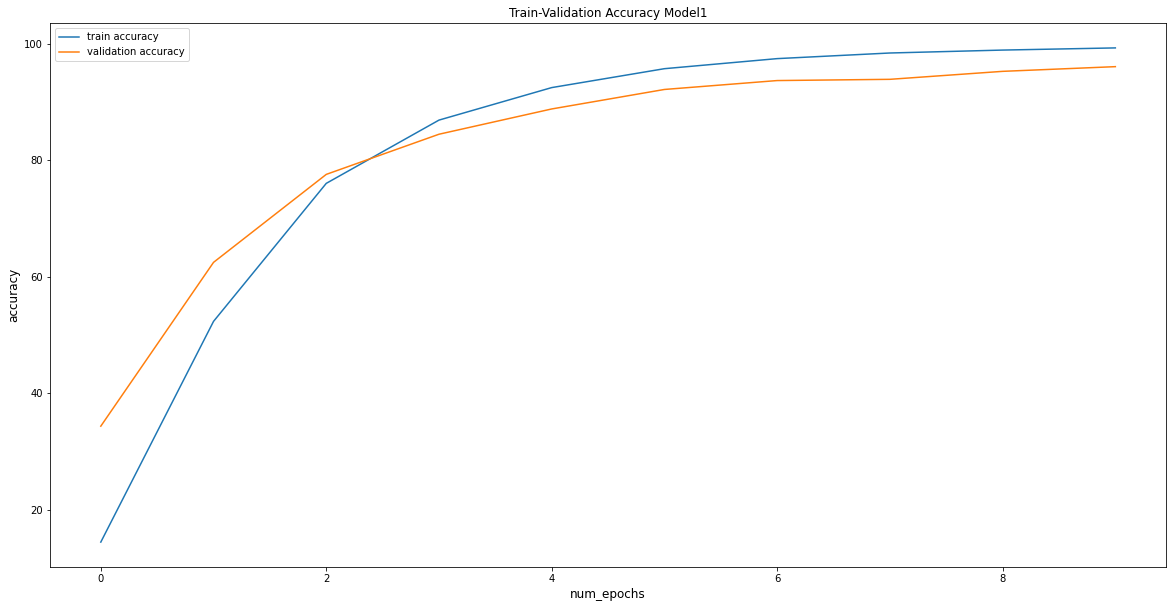

In [9]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy Model1")
plt.plot(train_acc1, label='train accuracy')
plt.plot(val_acc1, label='validation accuracy')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

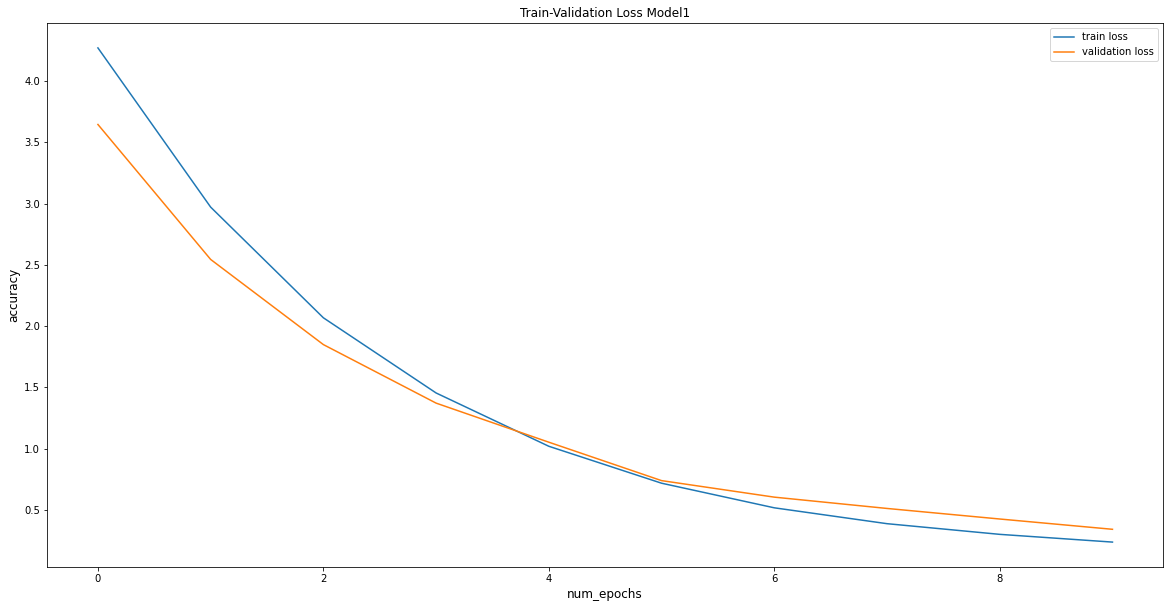

In [10]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Loss Model1")
plt.plot(train_loss1, label='train loss')
plt.plot(val_loss1, label='validation loss')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [38]:
def test_model(model,test_dataloader, d_device):
  total_t=0
  correct_t=0
  with torch.no_grad():
    for data_t, target_t in (test_dataloader):
      data_t, target_t = data_t.to(d_device), target_t.to(d_device)
      outputs_t = model(data_t)
      _,pred_t = torch.max(outputs_t, dim=1)
      correct_t += torch.sum(pred_t==target_t).item()
      total_t += target_t.size(0)
  print(f'test accuracy: {(100 * correct_t/total_t):.4f}')

In [32]:
test_model(model1,test_dataloader1,device)

test accuracy: 95.8568


In [13]:
def visualize_model(model_num, model, num_images, test_dataloader, test_dataset):
    images_so_far = 0
    fig = plt.figure(figsize=(8, 6.5))
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu()
        preds = preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('model {} predicted: {}{} true-label: {}'.format(model_num,test_dataset.classes[preds[j]],'\n', test_dataset.classes[labels[j]]))
            inputs = inputs.cpu()
            image = inputs[j].squeeze().permute(1,2,0)
            plt.imshow(image)
            
            if images_so_far == num_images:
                return 

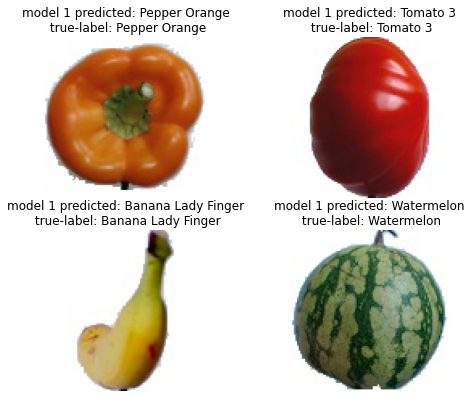

In [14]:
plt.ion()
visualize_model(1, model1, 4, test_dataloader1, test_dataset1)
plt.ioff()
# predictions of model 1

In [15]:
# define model 2 - Gray-Scale
model2_transforms = transforms.Compose(
[
    transforms.ToTensor(),
    transforms.Grayscale(3),
])

train_dataset2 = datasets.ImageFolder(root= train_data_path, transform=model2_transforms)
test_dataset2 = datasets.ImageFolder(root= test_data_path, transform=model2_transforms)
train_dataloader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
test_dataloader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=True)

model2 = models.resnet18(pretrained=False)
model2 = model2.cuda() if device else model2

criterion2 = nn.CrossEntropyLoss()
sgd_optimizer2 = optim.SGD(model2.parameters(), lr=0.0005, momentum=0.9)

num_features = model2.fc.in_features
model2.fc = nn.Linear(num_features, batch_size)
model2.fc = model2.fc.cuda()

In [16]:
# train model 2
train_acc2,val_acc2,train_loss2,val_loss2 = train_model(model2,epoches,criterion2,sgd_optimizer2,train_dataloader2,test_dataloader2,device)

Epoch [1/10]
train-loss: 4.3627, train-acc: 14.5202
validation-loss: 3.9180, validation-acc: 23.3075

Epoch [2/10]
train-loss: 3.8895, train-acc: 37.5687
validation-loss: 3.5827, validation-acc: 41.0525

Epoch [3/10]
train-loss: 3.5128, train-acc: 57.2106
validation-loss: 3.3039, validation-acc: 54.4781

Epoch [4/10]
train-loss: 3.1956, train-acc: 69.7852
validation-loss: 3.0516, validation-acc: 64.2013

Epoch [5/10]
train-loss: 2.9191, train-acc: 77.9944
validation-loss: 2.8350, validation-acc: 70.6673

Epoch [6/10]
train-loss: 2.6781, train-acc: 84.5521
validation-loss: 2.6438, validation-acc: 76.0666

Epoch [7/10]
train-loss: 2.4646, train-acc: 89.3400
validation-loss: 2.4813, validation-acc: 78.7509

Epoch [8/10]
train-loss: 2.2753, train-acc: 92.4806
validation-loss: 2.3482, validation-acc: 78.3850

Epoch [9/10]
train-loss: 2.1075, train-acc: 94.8325
validation-loss: 2.2116, validation-acc: 84.2736

Epoch [10/10]
train-loss: 1.9587, train-acc: 96.4161
validation-loss: 2.0937, vali

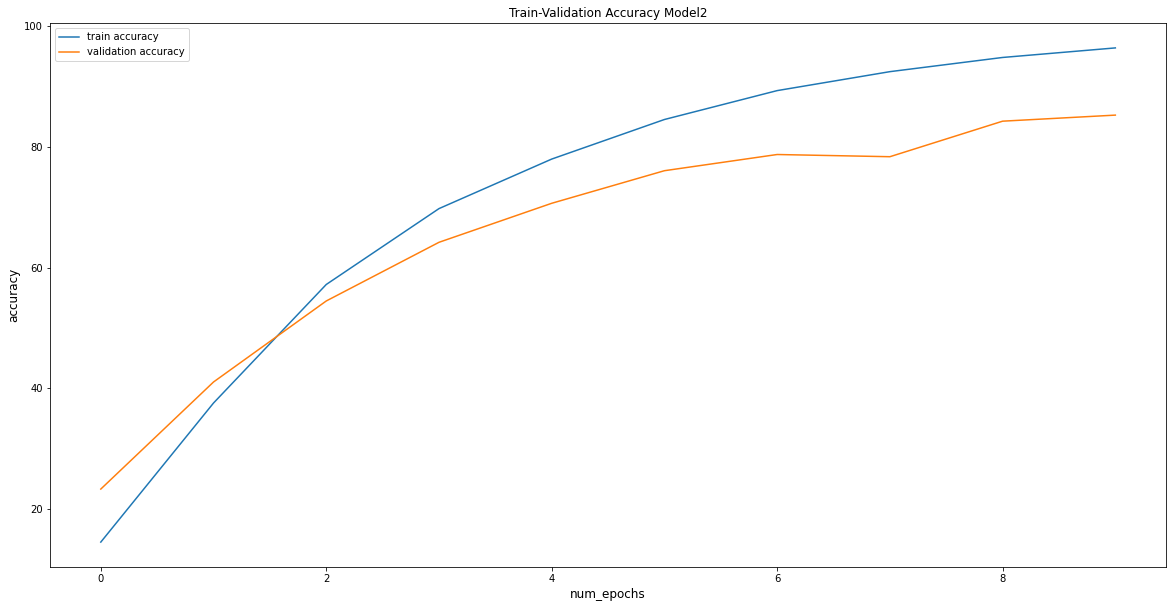

In [17]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy Model2")
plt.plot(train_acc2, label='train accuracy')
plt.plot(val_acc2, label='validation accuracy')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

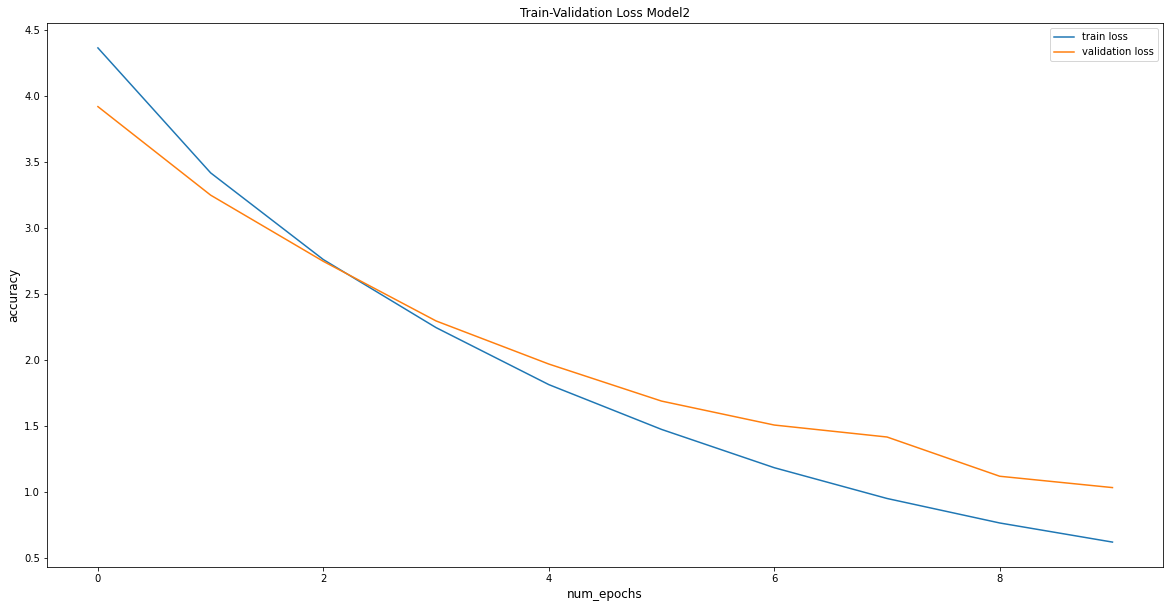

In [18]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Loss Model2")
plt.plot(train_loss2, label='train loss')
plt.plot(val_loss2, label='validation loss')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [19]:
test_model(model2,test_dataloader2,device)

test accuracy: 85.4372


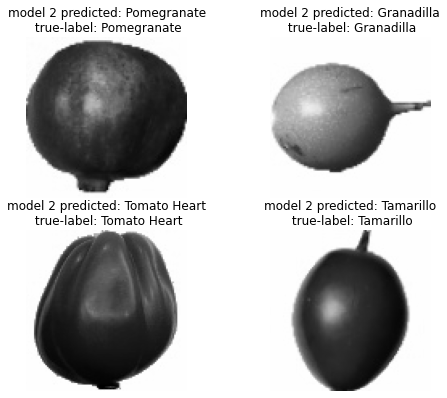

In [20]:
plt.ion()
visualize_model(2, model2, 4, test_dataloader2, test_dataset2)
plt.ioff()
# predictions of model 2

In [21]:
# define model 3 - Gaussian-Blur
model3_transforms = transforms.Compose(
[
    transforms.ToTensor(),
    transforms.GaussianBlur(5,(3,3)),
])

train_dataset3 = datasets.ImageFolder(root= train_data_path, transform=model3_transforms)
test_dataset3 = datasets.ImageFolder(root= test_data_path, transform=model3_transforms)
train_dataloader3 = DataLoader(train_dataset3, batch_size=batch_size, shuffle=True)
test_dataloader3 = DataLoader(test_dataset3, batch_size=batch_size, shuffle=True)

model3 = models.resnet18(pretrained=False)
model3 = model3.cuda() if device else model3

criterion3 = nn.CrossEntropyLoss()
sgd_optimizer3 = optim.SGD(model3.parameters(), lr=0.0005, momentum=0.9)

num_features = model3.fc.in_features
model3.fc = nn.Linear(num_features, batch_size)
model3.fc = model3.fc.cuda()

In [22]:
# train model 3
train_acc3,val_acc3,train_loss3,val_loss3 = train_model(model3,epoches,criterion3,sgd_optimizer3,train_dataloader3,test_dataloader3,device)

Epoch [1/10]
train-loss: 4.0913, train-acc: 20.1885
validation-loss: 3.4236, validation-acc: 38.2008

Epoch [2/10]
train-loss: 3.4504, train-acc: 54.8588
validation-loss: 2.9771, validation-acc: 60.6268

Epoch [3/10]
train-loss: 2.9681, train-acc: 75.8731
validation-loss: 2.5982, validation-acc: 76.1636

Epoch [4/10]
train-loss: 2.5798, train-acc: 87.5820
validation-loss: 2.2913, validation-acc: 83.4538

Epoch [5/10]
train-loss: 2.2617, train-acc: 92.5811
validation-loss: 2.0368, validation-acc: 88.2669

Epoch [6/10]
train-loss: 2.0032, train-acc: 95.2653
validation-loss: 1.8315, validation-acc: 91.2288

Epoch [7/10]
train-loss: 1.7925, train-acc: 96.9007
validation-loss: 1.6849, validation-acc: 90.8718

Epoch [8/10]
train-loss: 1.6191, train-acc: 97.9820
validation-loss: 1.5466, validation-acc: 92.2073

Epoch [9/10]
train-loss: 1.4746, train-acc: 98.6247
validation-loss: 1.4254, validation-acc: 94.3186

Epoch [10/10]
train-loss: 1.3530, train-acc: 99.0590
validation-loss: 1.3260, vali

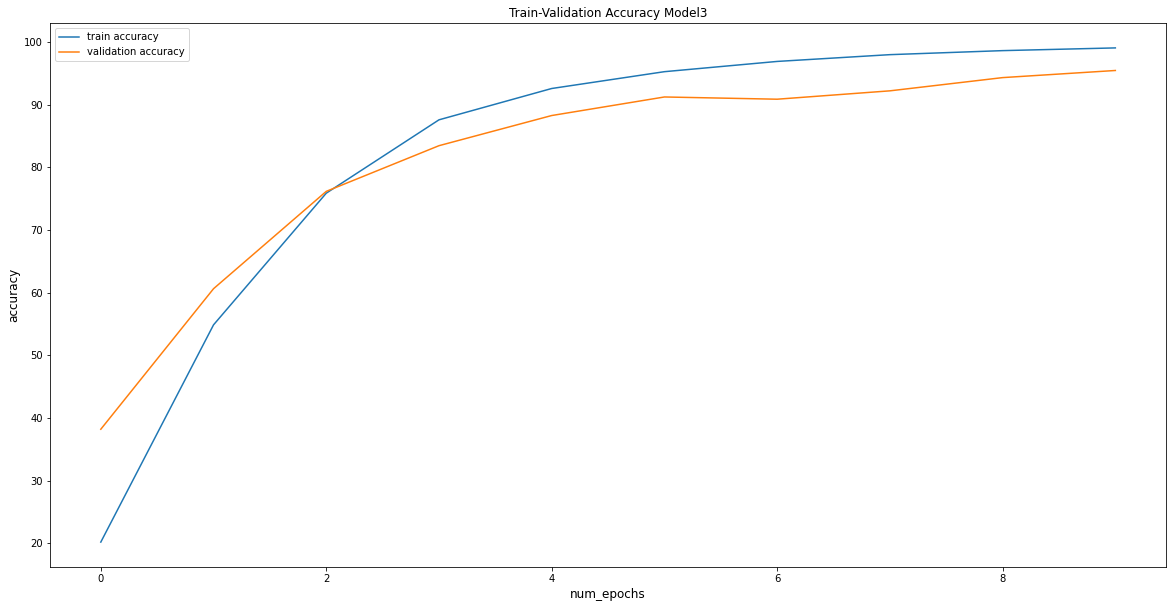

In [23]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy Model3")
plt.plot(train_acc3, label='train accuracy')
plt.plot(val_acc3, label='validation accuracy')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

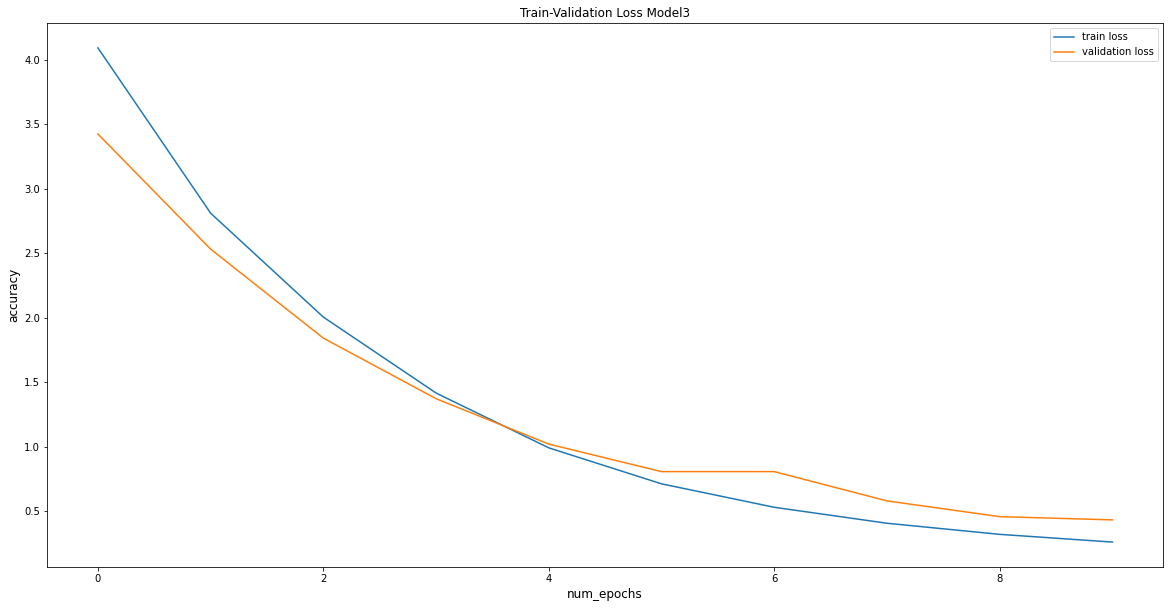

In [24]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Loss Model3")
plt.plot(train_loss3, label='train loss')
plt.plot(val_loss3, label='validation loss')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [25]:
test_model(model3,test_dataloader3,device)

test accuracy: 94.6756


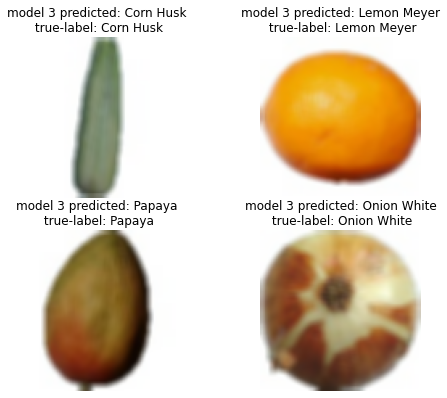

In [31]:
plt.ion()
visualize_model(3, model3, 4, test_dataloader3, test_dataset3)
plt.ioff()
# predictions of model 3

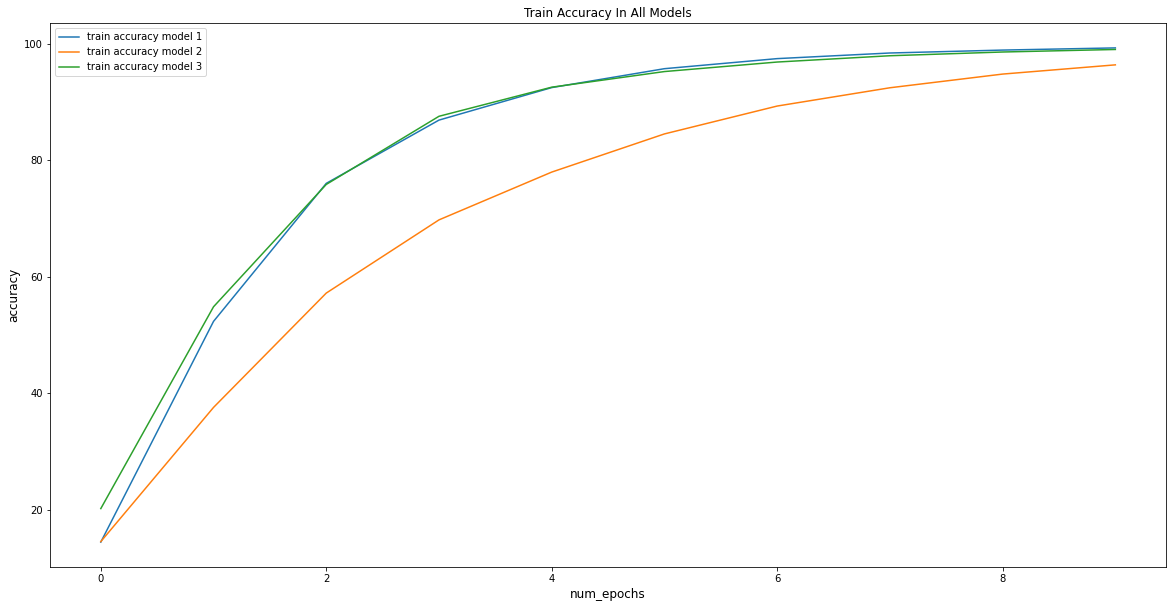

In [27]:
fig = plt.figure(figsize=(20,10))
plt.title("Train Accuracy In All Models")
plt.plot(train_acc1, label='train accuracy model 1')
plt.plot(train_acc2, label='train accuracy model 2')
plt.plot(train_acc3, label='train accuracy model 3')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
# compare the train accuracy in all models

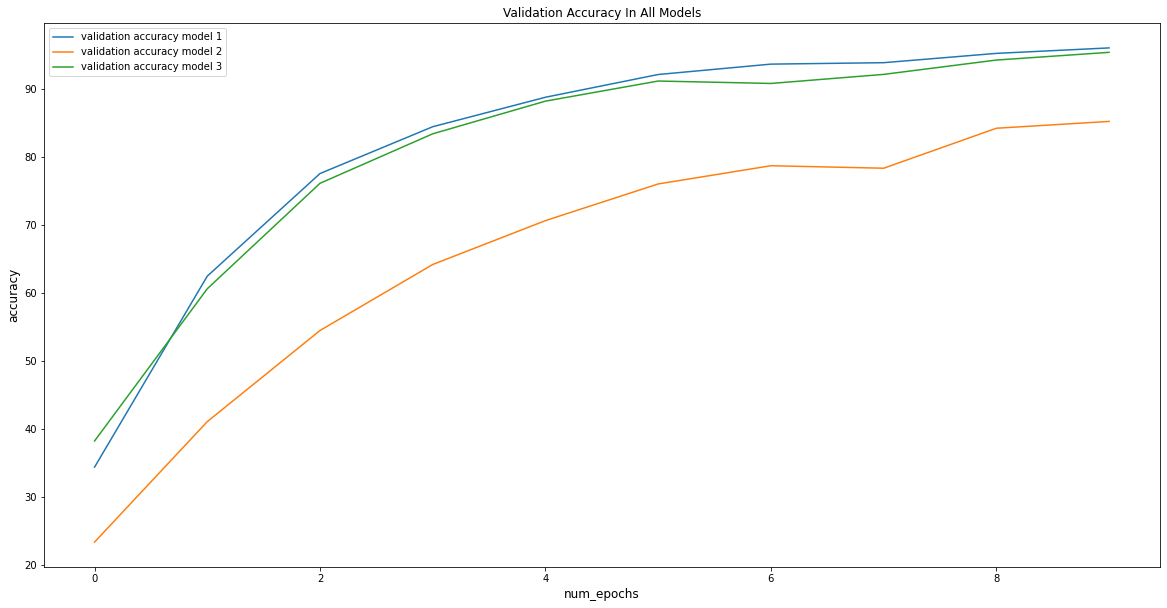

In [28]:
fig = plt.figure(figsize=(20,10))
plt.title("Validation Accuracy In All Models")
plt.plot(val_acc1, label='validation accuracy model 1')
plt.plot(val_acc2, label='validation accuracy model 2')
plt.plot(val_acc3, label='validation accuracy model 3')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
# compare the validation accuracy in all models

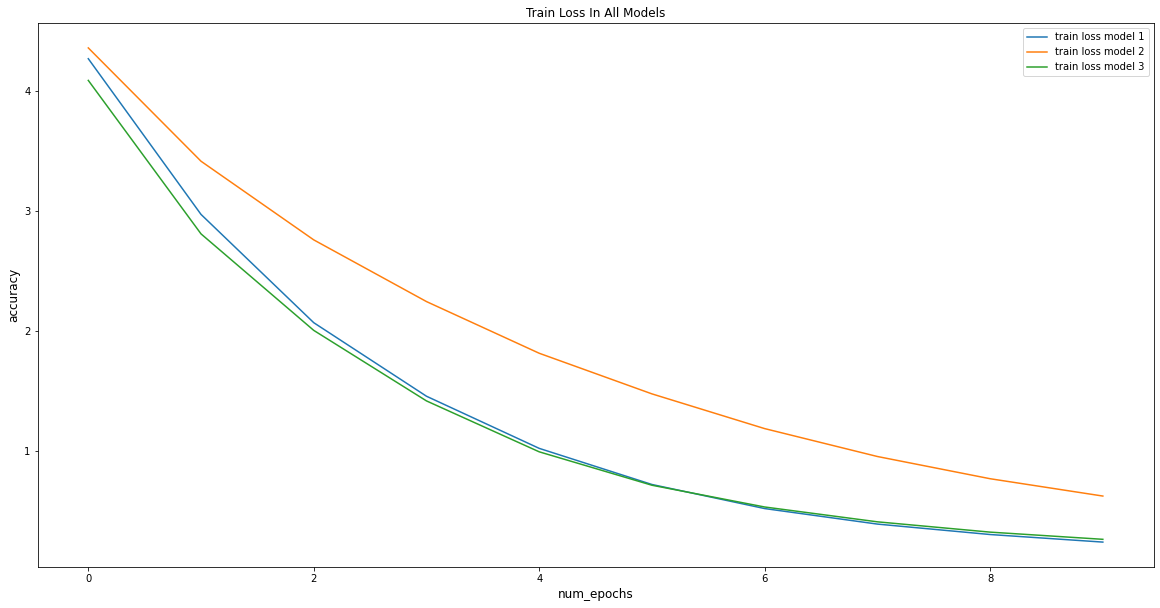

In [29]:
fig = plt.figure(figsize=(20,10))
plt.title("Train Loss In All Models")
plt.plot(train_loss1, label='train loss model 1')
plt.plot(train_loss2, label='train loss model 2')
plt.plot(train_loss3, label='train loss model 3')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
# compare the train loss in all models

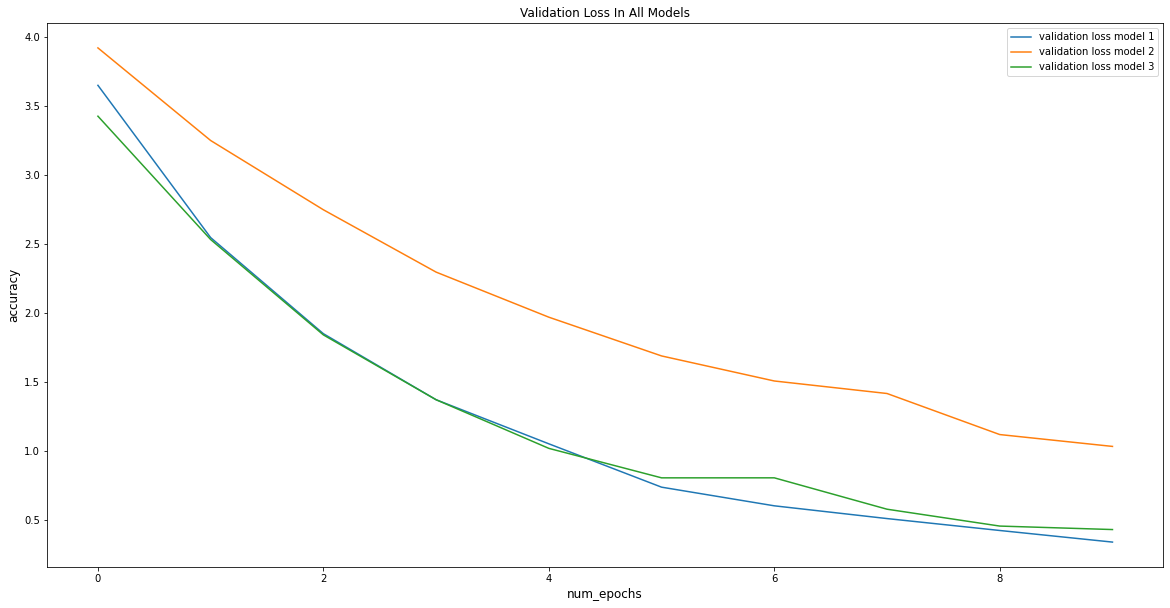

In [30]:
fig = plt.figure(figsize=(20,10))
plt.title("Validation Loss In All Models")
plt.plot(val_loss1, label='validation loss model 1')
plt.plot(val_loss2, label='validation loss model 2')
plt.plot(val_loss3, label='validation loss model 3')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
# compare the validation loss in all models